In [1]:
import numpy as np

from mpl_toolkits.mplot3d import Axes3D

import matplotlib as mpl
import matplotlib.pyplot as plt
import App.OctLayers as oct
import os
import pdb

%matplotlib inline
mpl.rcParams['figure.figsize'] = (10.0, 8.0)

In [2]:
#filepath = 'Data/Sample/Cirrus/Sample1/Macular Cube 512x128_01-01-2001_01-01-01_OS_sn41343_cube_z'
#img_file = filepath + '.img'
#surfaces_file = os.path.join(filepath,'Macular Cube 512x128_01-01-2001_01-01-01_OS_sn41343_cube_z_Surfaces_Iowa.xml')
#center_file = os.path.join(filepath,'Macular Cube 512x128_01-01-2001_01-01-01_OS_sn41343_cube_z_GridCenter_Iowa.xml')
filepath = 'Data/Sample/Bioptigen/sample_OD_V_12x12_0_0000010'
img_file = os.path.join(filepath,'sample_OD_V_12x12_0_0000010_OCT_Iowa.OCT')
surfaces_file = os.path.join(filepath,'sample_OD_V_12x12_0_0000010_Surfaces_Iowa.xml')
center_file = os.path.join(filepath, 'sample_OD_V_12x12_0_0000010_GridCenter_Iowa.xml')


In [3]:
data_oct = oct.OctLayers(filename = surfaces_file,
                         center_filename = center_file,
                         raw_filename = img_file)

In [4]:
def find_thickness(surface2, start_pixel, vector, step=0.1, start_t=0):
    #assert vector[2] > 0, "Vector in the wrong direction"
    found = False
    t = start_t
    
    while not found:
        t = t + step
        scaled_vec = t * vector
        new_pix = scaled_vec + start_pixel
        
        low_x = np.floor(new_pix[0])
        high_x = np.ceil(new_pix[0])
        low_y = np.floor(new_pix[1])
        high_y = np.ceil(new_pix[1])
        #import pdb; pdb.set_trace()
        
        # First check the new x,y coordinates are valid. If not return np.nan
        if new_pix[0] > surface2.shape[1] - 1  or new_pix[1] > surface2.shape[0] - 1 \
           or new_pix[0] < 0 or new_pix[1] < 0:
            #import pdb; pdb.set_trace()
            return np.nan
        
        # Check if both vector components are 0
        if np.isclose(scaled_vec[0], 0) and np.isclose(scaled_vec[1], 0):
            # no interpolation required
            new_val = surface2[new_pix[1], new_pix[0]]
            
        # now check if the new pixels fall exactly on a real pixel (ie. new_pix is an integer)
        if not (np.isclose(new_pix[0], int(new_pix[0])) or np.isclose(new_pix[1], int(new_pix[1]))):
            # bilinear interpolation
            points = [(low_x,low_y,surface2[low_y,low_x]),
                      (low_x,high_y,surface2[low_y,high_x]),
                      (high_x,low_y,surface2[high_y,low_x]),
                      (high_x,high_y,surface2[high_y,high_x])]
            new_val = bilinear_interpolation(new_pix[0], new_pix[1], points)
            
        elif np.isclose(new_pix[0], int(new_pix[0])):
            # only x pixel exists, linear interp on y
            new_val = np.interp(new_pix[1], [low_y,high_y],[surface2[low_y,new_pix[0]],
                                                            surface2[high_y,new_pix[0]]])
        elif np.isclose(new_pix[1], int(new_pix[1])):
            # only y vector component is 0, linear interp on x
            new_val = np.interp(new_pix[0], [low_x,high_x],[surface2[new_pix[1],low_x],
                                                            surface2[new_pix[1],high_x]])
        else:
            # no interpolation required
            new_val = surface2[start_pixel[1], start_pixel[0]]
                        
            
        if new_pix[2] <= new_val:
            vec_length = np.linalg.norm(t * vector)
            return t - step
        
def bilinear_interpolation(x, y, points):
    '''Interpolate (x,y) from values associated with four points.

    The four points are a list of four triplets:  (x, y, value).
    The four points can be in any order.  They should form a rectangle.

        >>> bilinear_interpolation(12, 5.5,
        ...                        [(10, 4, 100),
        ...                         (20, 4, 200),
        ...                         (10, 6, 150),
        ...                         (20, 6, 300)])
        165.0

    '''
    # See formula at:  http://en.wikipedia.org/wiki/Bilinear_interpolation

    points = sorted(points)               # order points by x, then by y
    (x1, y1, q11), (_x1, y2, q12), (x2, _y1, q21), (_x2, _y2, q22) = points

    if x1 != _x1 or x2 != _x2 or y1 != _y1 or y2 != _y2:
        pdb.pm()
        raise ValueError('points do not form a rectangle')
        
    if not x1 <= x <= x2 or not y1 <= y <= y2:
        raise ValueError('(x, y) not within the rectangle')

    return (q11 * (x2 - x) * (y2 - y) +
            q21 * (x - x1) * (y2 - y) +
            q12 * (x2 - x) * (y - y1) +
            q22 * (x - x1) * (y - y1)
           ) / ((x2 - x1) * (y2 - y1) + 0.0)



In [5]:
data_oct.data.data.shape

(11, 100, 1000)

In [5]:
my_surface2 = data_oct.data.data[0,:,:]
my_surface = data_oct.data.data[10,:,:]

In [7]:
my_surface.shape

(100, 1000)

In [ ]:
fig = plt.figure()
ax = fig.gca()

cmap = plt.get_cmap('gnuplot')

ax.set_color_cycle(['red', 'black', 'yellow','green'])
ax.set_ylim([0,1000])
for iline in range(0,my_surface.shape[0],32):
    ax.plot(range(my_surface.shape[1]),my_surface[iline,:])

In [6]:
# sample surface
#my_surface = np.array(np.arange(30), dtype=np.float).reshape(5,6)
#my_surface = np.random.random((5,6))
#my_surface = np.random.random((1024,1000))
#my_surface2 = my_surface + np.random.random(my_surface.shape)*10

calc_size = 2


# start and end points for each vector across a point
points = np.zeros((4,2),
                  dtype=[('x', 'i4'),('y', 'i4'),('z','f8')])
points[:,0]['x'] = [i * calc_size for i in [-1, 0, 1, 1]]
points[:,0]['y'] = [i * calc_size for i in [1, 1, 1, 0]]
points[:,1]['x'] = [i * calc_size for i in [1, 0, -1, -1]]
points[:,1]['y'] = [i * calc_size for i in [-1, -1, -1, 0]] 



# points[:,0][0:2] = [(-1,1),(0,1),(1,1),(1,0)]
# points[:,1][0:2] = [(1,-1),(0,-1),(-1,-1),(-1,0)]

# not going to calulate vectors for pixels on the edges of the surface
valid_size = (my_surface.shape[0]-(calc_size * 2)) * (my_surface.shape[1]-(calc_size * 2))

# the points array for each valid pixel
points = np.repeat(np.expand_dims(points,2),valid_size,2)

coords_x = range(calc_size,my_surface.shape[1]-calc_size)
coords_y = range(calc_size,my_surface.shape[0]-calc_size)

xv, yv = np.meshgrid(coords_x,coords_y, indexing='ij')

points[:,0,:]['x'] = points[:,0,:]['x'] + xv.flatten()
points[:,1,:]['x'] = points[:,1,:]['x'] + xv.flatten()
points[:,0,:]['y'] = points[:,0,:]['y'] + yv.flatten()
points[:,1,:]['y'] = points[:,1,:]['y'] + yv.flatten()


# points is now a 3d array [a, b, c]
# each datapoint is a coordinate (x,y,z)
# a = 4 - The number of vectors crossing each pixel
# b = 2 - Point coordinates of the end of each vector (0=start, 1=end)
# c = N number of valid pixels in the surface

In [9]:
points["y"].min()

0

In [7]:
# extract the z coordinates
x = points['x']
y = points['y']
points['z'] = my_surface[y,x]
#import pdb; pdb.set_trace()
# Calculate the vectors
vectors = np.empty((4,points.shape[2]),
                   dtype=[('x','f8'),('y','f8'),('z','f8')])
vectors['x'] = points[:,1,:]['x'] - points[:,0,:]['x']
vectors['y'] = points[:,1,:]['y'] - points[:,0,:]['y']
vectors['z'] = points[:,1,:]['z'] - points[:,0,:]['z']

# Define the vector pairs
pairs = np.array([(0,1),(0,2),(0,3),(1,2),(1,3),(2,3)], dtype=np.int)

normal_vector = np.empty(valid_size, dtype=(np.float,3))
vector_pairs = np.empty((6,2), dtype=(np.float,3))
normal_vectors = np.empty(my_surface.shape, dtype=(np.float,3))
normal_vectors[:] = np.nan
thicknesses = np.empty(my_surface.shape)
thicknesses[:] = np.nan

#voxel_sizes = [v for i,v in data_oct.voxel_size.items()]
voxel_sizes = [data_oct.voxel_size['x'], data_oct.voxel_size['y'], data_oct.voxel_size['z']]

In [ ]:
points[:,1,0]

In [ ]:
points[:,0,0]

In [ ]:
i=0
vectors["x"] = vectors["x"] * voxel_sizes[0]
vectors["y"] = vectors["y"] * voxel_sizes[1]
vectors["z"] = vectors["z"] * voxel_sizes[2]
vector_pairs[:, 0, :] = np.matrix([vectors[pairs[:,0], i]['x'],
                                   vectors[pairs[:,0], i]['y'],
                                   vectors[pairs[:,0], i]['z']]).transpose()
vector_pairs[:, 1, :] = np.matrix([vectors[pairs[:,1], i]['x'],
                                   vectors[pairs[:,1], i]['y'],
                                   vectors[pairs[:,1], i]['z']]).transpose()
vector_pairs

In [11]:
voxel_sizes

[12.0, 120.0, 2.393492]

In [ ]:
# calculate a normal vector for each vector pair
potential_vectors = np.cross(vector_pairs[:, 0],
                          vector_pairs[:, 1])

#import pdb; pdb.set_trace()
# average the 6 normal vectors to find the mean value for the pixel
normal_vector = potential_vectors.mean(axis=0) 
normal_vector

In [ ]:
normal_vector/voxel_sizes

In [ ]:
points[:,1,0]

In [ ]:
my_surface[0:5,0:5]

In [10]:
# convert voxels to microns
vectors["x"] = vectors["x"] * voxel_sizes[0]
vectors["y"] = vectors["y"] * voxel_sizes[1]
vectors["z"] = vectors["z"] * voxel_sizes[2]

old_pcomp = 0.0
for i in range(valid_size):
    pcomp = (float(i) / valid_size)*100
    if int(pcomp) > old_pcomp:
        old_pcomp = pcomp
        print('percent: {}'.format(int(pcomp)))
    # need to convert from structured arrays (np.void) to ndarray
    vector_pairs[:, 0, :] = np.matrix([vectors[pairs[:,0], i]['x'],
                                       vectors[pairs[:,0], i]['y'],
                                       vectors[pairs[:,0], i]['z']]).transpose()
    vector_pairs[:, 1, :] = np.matrix([vectors[pairs[:,1], i]['x'],
                                       vectors[pairs[:,1], i]['y'],
                                       vectors[pairs[:,1], i]['z']]).transpose()
    
    # convert the vector pairs from coordinates to microns
    #import pdb; pdb.set_trace()
    #vector_pairs[:, 0, :] = vector_pairs[:, 0, :] * voxel_sizes
    #vector_pairs[:, 1, :] = vector_pairs[:, 1, :] * voxel_sizes
    
    # calculate a normal vector for each vector pair
    potential_vectors = np.cross(vector_pairs[:, 0],
                              vector_pairs[:, 1])
    
    #import pdb; pdb.set_trace()
    # average the 6 normal vectors to find the mean value for the pixel
    normal_vector = potential_vectors.mean(axis=0) 
    
    # Normalise the vector to unit length
    normal_vector = normal_vector / np.linalg.norm(normal_vector)
    
    # Convert the vectors back into pixel coordinates
    normal_vector = normal_vector / voxel_sizes
    
    # The normal vector could be in either direction
    # TODO: need to add a check for direction
    if normal_vector[2] > 0:
        normal_vector = 0 - normal_vector
    #normal_vector[1] = 0    
    # create an array to hold the output thickness values
    #thicknesses = np.empty((my_surface.shape[0]-2,my_surface.shape[1]-2),
                           #dtype=(np.float,3))

    # note output from unravel is [y,x]
    start_pixel = np.unravel_index(i, (my_surface.shape[0]-(2 * calc_size),my_surface.shape[1]-(2 * calc_size)))
    
    # append the origin z coordinate to the start pixel
    surface_pixel = [val + calc_size for val in start_pixel]
    surface_pixel = surface_pixel[::-1]
    surface_pixel.append(my_surface[surface_pixel[1], surface_pixel[0]])
    
    # Store the normal vector incase I want it later
    normal_vectors[surface_pixel[1], surface_pixel[0]] = normal_vector
    #import pdb;pdb.set_trace()
    
    initial_t = find_thickness(my_surface2, surface_pixel, normal_vector, step=50)
    if np.isnan(initial_t):
        thicknesses[surface_pixel[1], surface_pixel[0]] = initial_t
    else:
        thicknesses[surface_pixel[1], surface_pixel[0]] = find_thickness(my_surface2, 
                                                                     surface_pixel, 
                                                                     normal_vector, 
                                                                     step=1, 
                                                                     start_t=initial_t)

percent: 1
percent: 2
percent: 3
percent: 4
percent: 5
percent: 6
percent: 7
percent: 8
percent: 9
percent: 10
percent: 11
percent: 12
percent: 13
percent: 14
percent: 15
percent: 16
percent: 17
percent: 18
percent: 19
percent: 20
percent: 21
percent: 22
percent: 23
percent: 24
percent: 25
percent: 26
percent: 27
percent: 28
percent: 29
percent: 30
percent: 31
percent: 32
percent: 33
percent: 34
percent: 35
percent: 36
percent: 37
percent: 38
percent: 39
percent: 40
percent: 41
percent: 42
percent: 43
percent: 44
percent: 45
percent: 46
percent: 47
percent: 48
percent: 49
percent: 50
percent: 51
percent: 52
percent: 53
percent: 54
percent: 55
percent: 56
percent: 57
percent: 58
percent: 59
percent: 60
percent: 61
percent: 62
percent: 63
percent: 64
percent: 65
percent: 66
percent: 67
percent: 68
percent: 69
percent: 70
percent: 71
percent: 72
percent: 73
percent: 74
percent: 75
percent: 76
percent: 77
percent: 78
percent: 79
percent: 80
percent: 81
percent: 82
percent: 83
percent: 84
p

In [ ]:
%debug

array([[ 0.        ,  0.        , -0.40613847],
       [ 0.        ,  0.        , -0.34174306],
       [ 0.06783443,  0.        , -0.37987278],
       [ 0.17599546,  0.        , -0.41065608],
       [ 0.13736056,  0.        , -0.54944226],
       [ 0.05227084,  0.        , -0.73179172],
       [ 0.08540114,  0.        , -0.79707732],
       [-0.07014306,  0.        , -0.98200287],
       [ 0.        ,  0.        , -0.49613894]])

KeyboardInterrupt: 

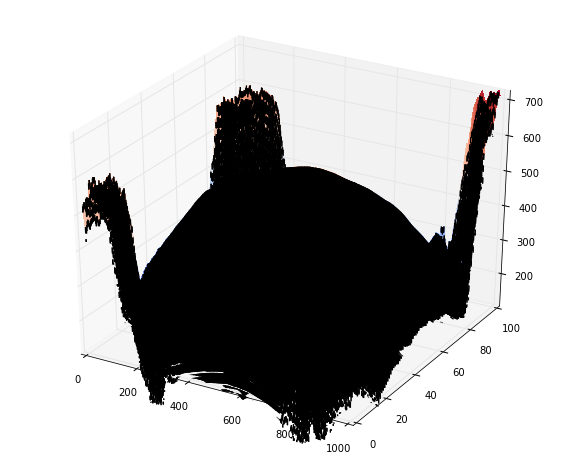

In [9]:
fig = plt.figure()
ax = fig.gca(projection='3d')
X, Y = np.meshgrid(np.arange(my_surface.shape[1]),
                   np.arange(my_surface.shape[0]))
Z = my_surface

surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap = mpl.cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.set_zlim(my_surface.min(), my_surface2.max())

for i in range(my_surface.size):
    y,x = np.unravel_index(i, my_surface.shape)
    X=[x,x]
    Y=[y,y]
    Z = [my_surface[y,x], my_surface2[y,x]]
    ax.plot(X,Y,Z, '--k')

for i in range(len(normal_vectors)):
    y,x = np.unravel_index(i, (my_surface.shape[0]-(2 * calc_size), my_surface.shape[1]-(2* calc_size)))
    y = y + calc_size
    x = x + calc_size
    v = normal_vectors[y,x]
    t = thicknesses[y, x]
    v = (v * t) + [x,y,my_surface[y,x]]
    X = [x, v[0]]
    Y = [y, v[1]]
    Z = [my_surface[y,x], v[2]]
    ax.plot(X,Y,Z, 'r')

X, Y = np.meshgrid(np.arange(my_surface.shape[1]),
               np.arange(my_surface.shape[0]))
Z = my_surface2
surf2 = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, antialiased=False)
    
plt.show()

In [13]:
# extract one slice of the raw oct and convert to RGB
my_slice = 60 # which B-scan slice
my_oct = data_oct.octdata[my_slice,:]
my_oct = np.expand_dims(my_oct,2)
my_oct = np.tile(my_oct,(1,1,3))

#my_oct = np.flipud(my_oct)
vector_slice = normal_vectors[my_slice,:]

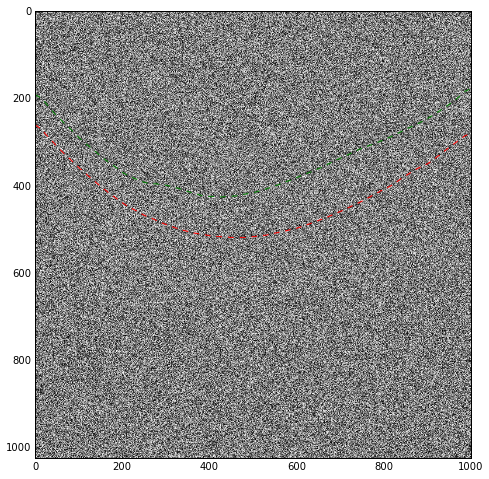

In [14]:
fig = plt.figure()
ax = fig.gca()
ax.imshow(my_oct)
ax.autoscale(False)
ax.plot(range(my_surface.shape[1]),my_surface[my_slice,:],'--r')
ax.plot(range(my_surface2.shape[1]),my_surface2[my_slice,:],'--g')

x_start:0, x_end:nan
x_start:20, x_end:14.0596498412
x_start:40, x_end:34.124284075
x_start:60, x_end:57.610121448
x_start:80, x_end:76.6485402987
x_start:100, x_end:95.9592959582
x_start:120, x_end:117.503116105
x_start:140, x_end:134.001584119
x_start:160, x_end:158.288975271
x_start:180, x_end:175.416156289
x_start:200, x_end:195.34495849
x_start:220, x_end:220.0
x_start:240, x_end:236.302163212
x_start:260, x_end:255.386238167
x_start:280, x_end:276.11036332
x_start:300, x_end:295.316236872
x_start:320, x_end:nan
x_start:340, x_end:333.119824392
x_start:360, x_end:356.545572068
x_start:380, x_end:373.725645124
x_start:400, x_end:394.937735936
x_start:420, x_end:nan
x_start:440, x_end:435.176155215
x_start:460, x_end:455.202927046
x_start:480, x_end:473.927483834
x_start:500, x_end:490.617126845
x_start:520, x_end:nan
x_start:540, x_end:534.825876928
x_start:560, x_end:554.790198862
x_start:580, x_end:575.231904246
x_start:600, x_end:595.215287347
x_start:620, x_end:nan
x_start:640,

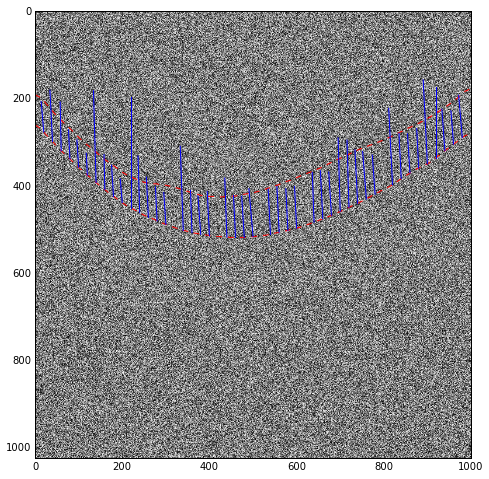

In [16]:
fig = plt.figure()
ax = fig.gca()
ax.imshow(my_oct)
ax.autoscale(False)
ax.plot(range(my_surface.shape[1]),my_surface[my_slice,:],'--r')
ax.plot(range(my_surface.shape[1]),my_surface2[my_slice,:],'--r')
#ax.set_ylim(450,800)
for iline in range(0,my_surface.shape[1],20):
    X_start = iline
    X_end = X_start + vector_slice[iline,0] * thicknesses[my_slice, iline]
    print('x_start:{}, x_end:{}'.format(X_start,X_end))
    Y_start = my_surface[my_slice, iline]
    Y_end = Y_start + vector_slice[iline,2] * thicknesses[my_slice, iline]
    ax.plot([X_start, X_end],[Y_start,Y_end],'b')

In [25]:
voxel_sizes

[12.0, 120.0, 2.393492]

x_start:0.0, x_end:nan
x_start:240.0, x_end:168.715798094
x_start:480.0, x_end:409.4914089
x_start:720.0, x_end:691.321457376
x_start:960.0, x_end:919.782483584
x_start:1200.0, x_end:1151.5115515
x_start:1440.0, x_end:1410.03739326
x_start:1680.0, x_end:1608.01900943
x_start:1920.0, x_end:1899.46770325
x_start:2160.0, x_end:2104.99387547
x_start:2400.0, x_end:2344.13950188
x_start:2640.0, x_end:2640.0
x_start:2880.0, x_end:2835.62595854
x_start:3120.0, x_end:3064.63485801
x_start:3360.0, x_end:3313.32435984
x_start:3600.0, x_end:3543.79484246
x_start:3840.0, x_end:nan
x_start:4080.0, x_end:3997.4378927
x_start:4320.0, x_end:4278.54686482
x_start:4560.0, x_end:4484.70774149
x_start:4800.0, x_end:4739.25283123
x_start:5040.0, x_end:nan
x_start:5280.0, x_end:5222.11386257
x_start:5520.0, x_end:5462.43512456
x_start:5760.0, x_end:5687.129806
x_start:6000.0, x_end:5887.40552214
x_start:6240.0, x_end:nan
x_start:6480.0, x_end:6417.91052314
x_start:6720.0, x_end:6657.48238634
x_start:6960.0, 

(0, 12000)

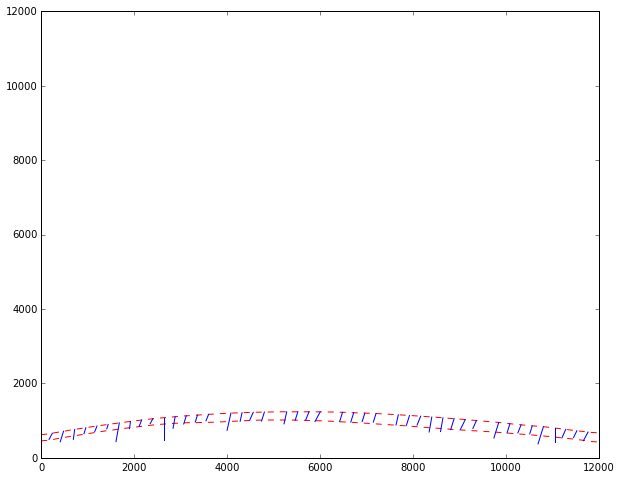

In [27]:
fig = plt.figure()
ax = fig.gca()
#ax.imshow(my_oct)
#ax.autoscale(False)
x_vals = [x * voxel_sizes[0] for x in range(my_surface.shape[1])]
ax.plot(x_vals, my_surface[my_slice,:] * voxel_sizes[2],'--r')
ax.plot(x_vals, my_surface2[my_slice,:] * voxel_sizes[2],'--r')
#ax.set_ylim(450,800)
for iline in range(0,my_surface.shape[1],20):
    X_start = iline * voxel_sizes[0]
    X_end = X_start + (vector_slice[iline,0] * thicknesses[my_slice, iline] * voxel_sizes[0])
    print('x_start:{}, x_end:{}'.format(X_start,X_end))
    Y_start = my_surface[my_slice, iline] * voxel_sizes[2]
    Y_end = Y_start + (vector_slice[iline,2] * thicknesses[my_slice, iline] * voxel_sizes[2])
    ax.plot([X_start, X_end],[Y_start,Y_end],'b')
ax.set_ylim(0,12000)

In [ ]:
thicknesses[my_slice,]

In [ ]:
X_start = iline + 150
X_end = X_start + vector_slice[iline,0] * thicknesses[14, iline]
[X_start, X_end]

In [ ]:
vector_slice[iline,:]

In [ ]:
thicknesses[14, iline]

In [ ]:
X_end

In [ ]:
X_start

In [ ]:
np.all(np.isnan(thicknesses))

In [ ]:
thicknesses

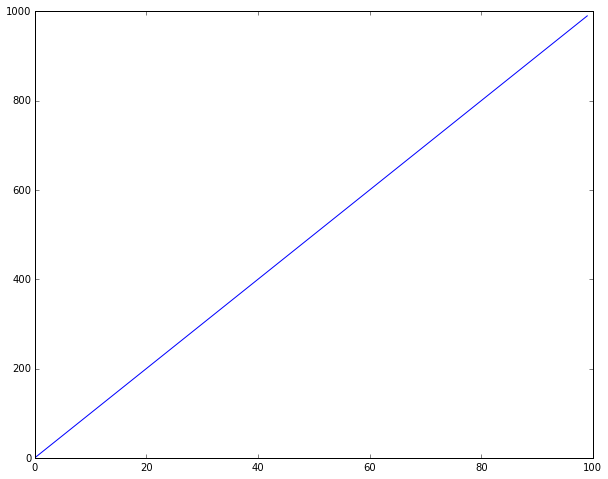

In [18]:
fig = plt.figure()
ax = fig.gca()
ax.plot(range(0,100,1),range(0,1000,10))